In [1]:
%matplotlib inline
#Python
import math, time, random, datetime

#Data Manipulations
import numpy as np
import pandas as pd
import seaborn as sns


#Visuals
import matplotlib.pyplot as plt
import missingno

# Preprocessing
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, label_binarize

# Machine learning
import catboost
from sklearn.model_selection import train_test_split
from sklearn import model_selection, tree, preprocessing, metrics, linear_model
from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression, LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier, Pool, cv



In [2]:
import catboost

In [3]:
import pandas as pd

In [4]:
#Import train & test data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
gender_submission = pd.read_csv('gender_submission.csv')

In [5]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
df_bin = pd.DataFrame() # for discretised continuous variables
df_con = pd.DataFrame() # for continuous variables

In [7]:
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

0    549
1    342
Name: Survived, dtype: int64


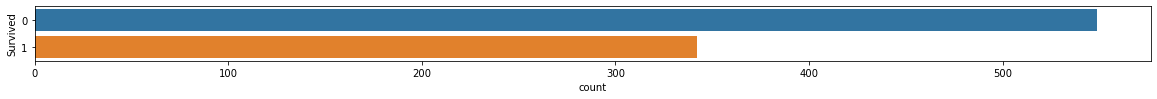

In [8]:
#Plotting survival rates 
fig = plt.figure(figsize=(20,1))
sns.countplot(y='Survived', data=train)
print(train.Survived.value_counts())

In [9]:
#Creating bins 
df_bin['Survived'] = train['Survived']
df_con['Survived'] = train['Survived']

df_bin['Pclass'] = train['Pclass']
df_con['Pclass'] = train['Pclass']

df_bin['Sex'] = train['Sex']
df_bin['Sex'] = np.where(df_bin['Sex'] == 'female', 1, 0) # change sex to 0 for male and 1 for female
df_con['Sex'] = train['Sex']

In [10]:
# df_bin['Age'] = pd.cut(train['Age'], 10) # bucketed/binned into different categories
# df_con['Age'] = train['Age'] # non-bucketed
# df_con = df_con.dropna(subset=['Age'])
# df_bin = df_bin.dropna(subset=['Age'])

df_bin['SibSp'] = train['SibSp']
df_con['SibSp'] = train['SibSp']

df_bin['Parch'] = train['Parch']
df_con['Parch'] = train['Parch']


In [11]:
df_con['Fare'] = train['Fare'] 
df_bin['Fare'] = pd.cut(train['Fare'], bins=5) 

df_bin['Embarked'] = train['Embarked']
df_con['Embarked'] = train['Embarked']
df_con = df_con.dropna(subset=['Embarked'])
df_bin = df_bin.dropna(subset=['Embarked'])

In [15]:
#Converting cat data into indicator variable 
df_embarked_one_hot = pd.get_dummies(df_con['Embarked'], 
                                     prefix='embarked')

df_sex_one_hot = pd.get_dummies(df_con['Sex'], 
                                prefix='sex')

df_plcass_one_hot = pd.get_dummies(df_con['Pclass'], 
                                   prefix='pclass')


# df_age_one_hot = pd.get_dummies(df_con['Age'], 
#                                    prefix='Age')

In [16]:
df_con_enc = pd.concat([df_con, 
                        df_embarked_one_hot, 
                        df_sex_one_hot, 
                        df_plcass_one_hot], axis=1)

# Drop the original categorical columns (because now they've been one hot encoded)
df_con_enc = df_con_enc.drop(['Pclass', 'Sex', 'Embarked'], axis=1)

In [17]:
df_con_enc

,Survived,SibSp,Parch,Fare,embarked_C,embarked_Q,embarked_S,sex_female,sex_male,pclass_1,pclass_2,pclass_3
0,0,1,0,7.2500,0,0,1,0,1,0,0,1
1,1,1,0,71.2833,1,0,0,1,0,1,0,0
2,1,0,0,7.9250,0,0,1,1,0,0,0,1
3,1,1,0,53.1000,0,0,1,1,0,1,0,0
4,0,0,0,8.0500,0,0,1,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,0,0,13.0000,0,0,1,0,1,0,1,0
887,1,0,0,30.0000,0,0,1,1,0,1,0,0
888,0,1,2,23.4500,0,0,1,1,0,0,0,1
889,1,0,0,30.0000,1,0,0,0,1,1,0,0


In [18]:
# ML Building 

selected_df = df_con_enc
X_train = selected_df.drop('Survived', axis=1) # data
y_train = selected_df.Survived # labels

In [19]:
# Function that runs the requested algorithm and returns the accuracy metrics
def fit_ml_algo(algo, X_train, y_train, cv):
    # One Pass
    model = algo.fit(X_train, y_train)
    acc = round(model.score(X_train, y_train) * 100, 2)
    # Cross Validation 
    train_pred = model_selection.cross_val_predict(algo, 
                                                  X_train, 
                                                  y_train, 
                                                  cv=cv, 
                                                  n_jobs = -1)
    # Cross-validation accuracy metric
    acc_cv = round(metrics.accuracy_score(y_train, train_pred) * 100, 2)
    return train_pred, acc, acc_cv

In [20]:
#Log Regression
start_time = time.time()
train_pred_log, acc_log, acc_cv_log = fit_ml_algo(LogisticRegression(max_iter = 10000), 
                                                               X_train, 
                                                               y_train, 
                                                                    10)
log_time = (time.time() - start_time)
print("Accuracy: %s" % acc_log)
print("Accuracy CV 10-Fold: %s" % acc_cv_log)
print("Running Time: %s" % datetime.timedelta(seconds=log_time))

Accuracy: 79.98
Accuracy CV 10-Fold: 79.42
Running Time: 0:01:17.406263


In [21]:
# k-Nearest Neighbours
start_time = time.time()
train_pred_knn, acc_knn, acc_cv_knn = fit_ml_algo(KNeighborsClassifier(), 
                                                  X_train, 
                                                  y_train, 
                                                  10)
knn_time = (time.time() - start_time)
print("Accuracy: %s" % acc_knn)
print("Accuracy CV 10-Fold: %s" % acc_cv_knn)
print("Running Time: %s" % datetime.timedelta(seconds=knn_time))

Accuracy: 83.46
Accuracy CV 10-Fold: 76.72
Running Time: 0:00:02.951612


In [22]:
# Gaussian Naive Bayes
start_time = time.time()
train_pred_gaussian, acc_gaussian, acc_cv_gaussian = fit_ml_algo(GaussianNB(), 
                                                                      X_train, 
                                                                      y_train, 
                                                                           10)
gaussian_time = (time.time() - start_time)
print("Accuracy: %s" % acc_gaussian)
print("Accuracy CV 10-Fold: %s" % acc_cv_gaussian)
print("Running Time: %s" % datetime.timedelta(seconds=gaussian_time))

Accuracy: 78.52
Accuracy CV 10-Fold: 77.95
Running Time: 0:00:00.603409


In [23]:
# Linear SVC
start_time = time.time()
train_pred_svc, acc_linear_svc, acc_cv_linear_svc = fit_ml_algo(LinearSVC(),
                                                                X_train, 
                                                                y_train, 
                                                                10)
linear_svc_time = (time.time() - start_time)
print("Accuracy: %s" % acc_linear_svc)
print("Accuracy CV 10-Fold: %s" % acc_cv_linear_svc)
print("Running Time: %s" % datetime.timedelta(seconds=linear_svc_time))

C:\Users\maxim\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Accuracy: 77.95
Accuracy CV 10-Fold: 77.05
Running Time: 0:00:01.849655


In [24]:
# Stochastic Gradient Descent
start_time = time.time()
train_pred_sgd, acc_sgd, acc_cv_sgd = fit_ml_algo(SGDClassifier(), 
                                                  X_train, 
                                                  y_train,
                                                  10)
sgd_time = (time.time() - start_time)
print("Accuracy: %s" % acc_sgd)
print("Accuracy CV 10-Fold: %s" % acc_cv_sgd)
print("Running Time: %s" % datetime.timedelta(seconds=sgd_time))

Accuracy: 62.43
Accuracy CV 10-Fold: 72.44
Running Time: 0:00:00.805628


In [25]:
# Decision Tree Classifier
start_time = time.time()
train_pred_dt, acc_dt, acc_cv_dt = fit_ml_algo(DecisionTreeClassifier(), 
                                                                X_train, 
                                                                y_train,
                                                                10)
dt_time = (time.time() - start_time)
print("Accuracy: %s" % acc_dt)
print("Accuracy CV 10-Fold: %s" % acc_cv_dt)
print("Running Time: %s" % datetime.timedelta(seconds=dt_time))

Accuracy: 92.46
Accuracy CV 10-Fold: 80.31
Running Time: 0:00:00.927875


In [26]:
# Gradient Boosting Trees
start_time = time.time()
train_pred_gbt, acc_gbt, acc_cv_gbt = fit_ml_algo(GradientBoostingClassifier(), 
                                                                       X_train, 
                                                                       y_train,
                                                                       10)
gbt_time = (time.time() - start_time)
print("Accuracy: %s" % acc_gbt)
print("Accuracy CV 10-Fold: %s" % acc_cv_gbt)
print("Running Time: %s" % datetime.timedelta(seconds=gbt_time))

Accuracy: 86.61
Accuracy CV 10-Fold: 80.65
Running Time: 0:00:07.992514


In [27]:
#CatBoost Algo
cat_features = np.where(X_train.dtypes != np.float)[0]
cat_features
train_pool = Pool(X_train, 
                  y_train,
                  cat_features)

<ipython-input-27-faa4148cbc9f>:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  cat_features = np.where(X_train.dtypes != np.float)[0]


In [28]:
# CatBoost model definition
catboost_model = CatBoostClassifier(iterations=1000,
                                    custom_loss=['Accuracy'],
                                    loss_function='Logloss')

# Fit CatBoost model
catboost_model.fit(train_pool,
                   plot=True)

# CatBoost accuracy
acc_catboost = round(catboost_model.score(X_train, y_train) * 100, 2)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.009797
0:	learn: 0.6862830	total: 756ms	remaining: 12m 35s
1:	learn: 0.6809444	total: 1.19s	remaining: 9m 51s
2:	learn: 0.6751692	total: 1.66s	remaining: 9m 12s
3:	learn: 0.6689060	total: 2.13s	remaining: 8m 50s
4:	learn: 0.6632144	total: 2.74s	remaining: 9m 4s
5:	learn: 0.6576488	total: 3.27s	remaining: 9m 1s
6:	learn: 0.6544441	total: 3.35s	remaining: 7m 55s
7:	learn: 0.6490635	total: 4.02s	remaining: 8m 18s
8:	learn: 0.6443241	total: 4.37s	remaining: 8m 1s
9:	learn: 0.6395935	total: 4.96s	remaining: 8m 11s
10:	learn: 0.6345186	total: 5.31s	remaining: 7m 57s
11:	learn: 0.6305316	total: 5.7s	remaining: 7m 49s
12:	learn: 0.6275610	total: 5.9s	remaining: 7m 27s
13:	learn: 0.6225020	total: 6.89s	remaining: 8m 5s
14:	learn: 0.6179503	total: 8.89s	remaining: 9m 43s
15:	learn: 0.6140480	total: 9.16s	remaining: 9m 23s
16:	learn: 0.6100034	total: 10.3s	remaining: 9m 54s
17:	learn: 0.6049646	total: 11.1s	remaining: 10m 8s
18:	learn: 0.6025760	total: 11.3s	remaining: 9m 4

158:	learn: 0.4248393	total: 1m 2s	remaining: 5m 32s
159:	learn: 0.4245472	total: 1m 3s	remaining: 5m 32s
160:	learn: 0.4243067	total: 1m 3s	remaining: 5m 32s
161:	learn: 0.4240101	total: 1m 4s	remaining: 5m 32s
162:	learn: 0.4236345	total: 1m 4s	remaining: 5m 32s
163:	learn: 0.4234396	total: 1m 5s	remaining: 5m 32s
164:	learn: 0.4228926	total: 1m 5s	remaining: 5m 31s
165:	learn: 0.4227463	total: 1m 6s	remaining: 5m 31s
166:	learn: 0.4226186	total: 1m 6s	remaining: 5m 31s
167:	learn: 0.4222141	total: 1m 7s	remaining: 5m 32s
168:	learn: 0.4219366	total: 1m 7s	remaining: 5m 31s
169:	learn: 0.4216245	total: 1m 8s	remaining: 5m 32s
170:	learn: 0.4213900	total: 1m 8s	remaining: 5m 32s
171:	learn: 0.4210836	total: 1m 9s	remaining: 5m 32s
172:	learn: 0.4208199	total: 1m 9s	remaining: 5m 33s
173:	learn: 0.4206421	total: 1m 10s	remaining: 5m 32s
174:	learn: 0.4201114	total: 1m 10s	remaining: 5m 32s
175:	learn: 0.4198212	total: 1m 11s	remaining: 5m 32s
176:	learn: 0.4195834	total: 1m 11s	remaini

311:	learn: 0.3940320	total: 2m 5s	remaining: 4m 37s
312:	learn: 0.3938485	total: 2m 6s	remaining: 4m 37s
313:	learn: 0.3937877	total: 2m 6s	remaining: 4m 36s
314:	learn: 0.3937594	total: 2m 6s	remaining: 4m 35s
315:	learn: 0.3937379	total: 2m 7s	remaining: 4m 35s
316:	learn: 0.3935486	total: 2m 7s	remaining: 4m 35s
317:	learn: 0.3934677	total: 2m 8s	remaining: 4m 35s
318:	learn: 0.3934339	total: 2m 8s	remaining: 4m 35s
319:	learn: 0.3932612	total: 2m 9s	remaining: 4m 35s
320:	learn: 0.3932174	total: 2m 9s	remaining: 4m 34s
321:	learn: 0.3932150	total: 2m 9s	remaining: 4m 33s
322:	learn: 0.3932132	total: 2m 10s	remaining: 4m 32s
323:	learn: 0.3931313	total: 2m 10s	remaining: 4m 32s
324:	learn: 0.3931290	total: 2m 10s	remaining: 4m 31s
325:	learn: 0.3930115	total: 2m 11s	remaining: 4m 31s
326:	learn: 0.3929436	total: 2m 11s	remaining: 4m 30s
327:	learn: 0.3928210	total: 2m 11s	remaining: 4m 30s
328:	learn: 0.3926321	total: 2m 12s	remaining: 4m 29s
329:	learn: 0.3926315	total: 2m 12s	rem

465:	learn: 0.3792293	total: 3m 6s	remaining: 3m 34s
466:	learn: 0.3791163	total: 3m 7s	remaining: 3m 33s
467:	learn: 0.3790884	total: 3m 7s	remaining: 3m 33s
468:	learn: 0.3790051	total: 3m 8s	remaining: 3m 32s
469:	learn: 0.3788248	total: 3m 8s	remaining: 3m 32s
470:	learn: 0.3788226	total: 3m 8s	remaining: 3m 31s
471:	learn: 0.3787820	total: 3m 8s	remaining: 3m 31s
472:	learn: 0.3787817	total: 3m 8s	remaining: 3m 30s
473:	learn: 0.3787174	total: 3m 9s	remaining: 3m 29s
474:	learn: 0.3787129	total: 3m 9s	remaining: 3m 29s
475:	learn: 0.3786589	total: 3m 9s	remaining: 3m 28s
476:	learn: 0.3785313	total: 3m 10s	remaining: 3m 28s
477:	learn: 0.3784696	total: 3m 10s	remaining: 3m 27s
478:	learn: 0.3781854	total: 3m 10s	remaining: 3m 27s
479:	learn: 0.3781808	total: 3m 11s	remaining: 3m 27s
480:	learn: 0.3781808	total: 3m 11s	remaining: 3m 26s
481:	learn: 0.3781223	total: 3m 11s	remaining: 3m 26s
482:	learn: 0.3780117	total: 3m 12s	remaining: 3m 26s
483:	learn: 0.3780103	total: 3m 12s	rem

618:	learn: 0.3674936	total: 3m 53s	remaining: 2m 23s
619:	learn: 0.3674703	total: 3m 53s	remaining: 2m 23s
620:	learn: 0.3674295	total: 3m 53s	remaining: 2m 22s
621:	learn: 0.3674261	total: 3m 54s	remaining: 2m 22s
622:	learn: 0.3673472	total: 3m 54s	remaining: 2m 22s
623:	learn: 0.3672394	total: 3m 55s	remaining: 2m 21s
624:	learn: 0.3671017	total: 3m 55s	remaining: 2m 21s
625:	learn: 0.3669262	total: 3m 55s	remaining: 2m 20s
626:	learn: 0.3668421	total: 3m 56s	remaining: 2m 20s
627:	learn: 0.3667561	total: 3m 56s	remaining: 2m 20s
628:	learn: 0.3667090	total: 3m 56s	remaining: 2m 19s
629:	learn: 0.3666052	total: 3m 57s	remaining: 2m 19s
630:	learn: 0.3665458	total: 3m 57s	remaining: 2m 18s
631:	learn: 0.3665288	total: 3m 57s	remaining: 2m 18s
632:	learn: 0.3663299	total: 3m 58s	remaining: 2m 18s
633:	learn: 0.3662989	total: 3m 58s	remaining: 2m 17s
634:	learn: 0.3660778	total: 3m 59s	remaining: 2m 17s
635:	learn: 0.3660162	total: 3m 59s	remaining: 2m 17s
636:	learn: 0.3659403	total:

772:	learn: 0.3564696	total: 4m 44s	remaining: 1m 23s
773:	learn: 0.3563506	total: 4m 44s	remaining: 1m 23s
774:	learn: 0.3562620	total: 4m 45s	remaining: 1m 22s
775:	learn: 0.3562524	total: 4m 45s	remaining: 1m 22s
776:	learn: 0.3562429	total: 4m 45s	remaining: 1m 21s
777:	learn: 0.3561846	total: 4m 45s	remaining: 1m 21s
778:	learn: 0.3560209	total: 4m 45s	remaining: 1m 21s
779:	learn: 0.3560116	total: 4m 46s	remaining: 1m 20s
780:	learn: 0.3559330	total: 4m 46s	remaining: 1m 20s
781:	learn: 0.3559321	total: 4m 46s	remaining: 1m 19s
782:	learn: 0.3559229	total: 4m 47s	remaining: 1m 19s
783:	learn: 0.3558345	total: 4m 47s	remaining: 1m 19s
784:	learn: 0.3557393	total: 4m 47s	remaining: 1m 18s
785:	learn: 0.3557326	total: 4m 47s	remaining: 1m 18s
786:	learn: 0.3555509	total: 4m 48s	remaining: 1m 17s
787:	learn: 0.3554902	total: 4m 48s	remaining: 1m 17s
788:	learn: 0.3554292	total: 4m 48s	remaining: 1m 17s
789:	learn: 0.3553073	total: 4m 49s	remaining: 1m 16s
790:	learn: 0.3552256	total:

927:	learn: 0.3451955	total: 5m 48s	remaining: 27s
928:	learn: 0.3451594	total: 5m 48s	remaining: 26.6s
929:	learn: 0.3451240	total: 5m 49s	remaining: 26.3s
930:	learn: 0.3450443	total: 5m 49s	remaining: 25.9s
931:	learn: 0.3449495	total: 5m 49s	remaining: 25.5s
932:	learn: 0.3448684	total: 5m 50s	remaining: 25.1s
933:	learn: 0.3448617	total: 5m 50s	remaining: 24.8s
934:	learn: 0.3448072	total: 5m 50s	remaining: 24.4s
935:	learn: 0.3447133	total: 5m 51s	remaining: 24s
936:	learn: 0.3444531	total: 5m 51s	remaining: 23.6s
937:	learn: 0.3443336	total: 5m 51s	remaining: 23.3s
938:	learn: 0.3441200	total: 5m 52s	remaining: 22.9s
939:	learn: 0.3440795	total: 5m 52s	remaining: 22.5s
940:	learn: 0.3439372	total: 5m 52s	remaining: 22.1s
941:	learn: 0.3437031	total: 5m 53s	remaining: 21.8s
942:	learn: 0.3436501	total: 5m 53s	remaining: 21.4s
943:	learn: 0.3436005	total: 5m 54s	remaining: 21s
944:	learn: 0.3435516	total: 5m 54s	remaining: 20.6s
945:	learn: 0.3434581	total: 5m 54s	remaining: 20.2s

,imp,col
4,0.992061,embarked_Q
3,1.213711,embarked_C
5,1.677219,embarked_S
9,2.178083,pclass_2
8,3.243021,pclass_1
0,10.797435,SibSp
10,11.205450,pclass_3
1,13.988886,Parch
2,15.753218,Fare
6,17.695520,sex_female


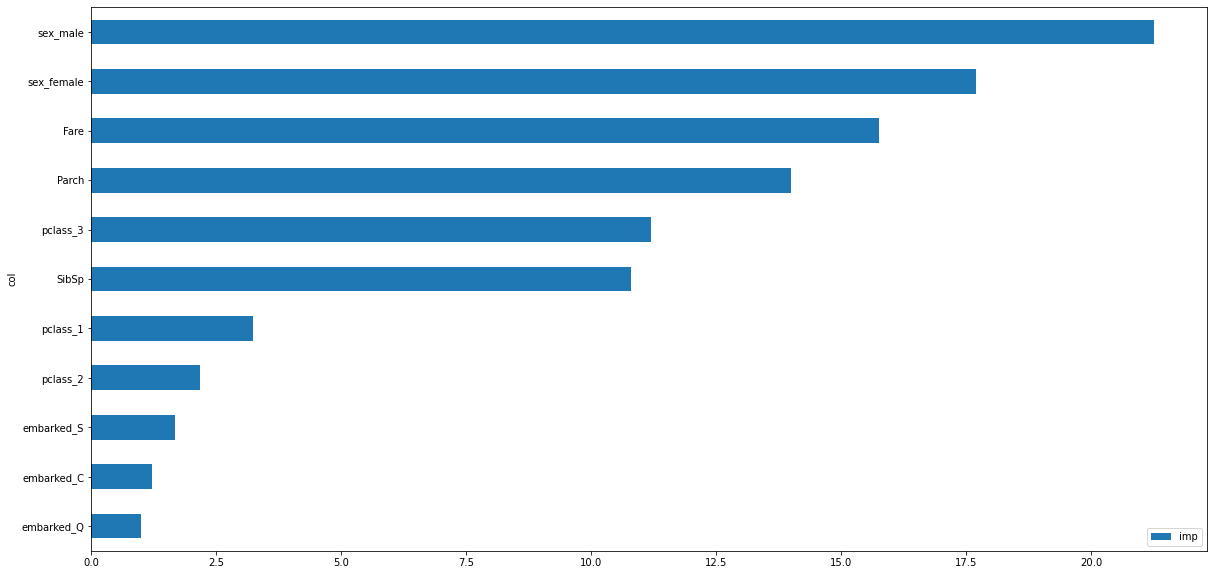

In [29]:
def feature_importance(model, data):
    """
    Function to show which features are most important in the model.
    ::param_model:: Which model to use?
    ::param_data:: What data to use?
    """
    fea_imp = pd.DataFrame({'imp': model.feature_importances_, 'col': data.columns})
    fea_imp = fea_imp.sort_values(['imp', 'col'], ascending=[True, False]).iloc[-30:]
    _ = fea_imp.plot(kind='barh', x='col', y='imp', figsize=(20, 10))
    return fea_imp
    #plt.savefig('catboost_feature_importance.png') 
feature_importance(catboost_model, X_train)

In [30]:
acc_catboost

83.91

In [31]:
start_time = time.time()

# Set params for cross-validation as same as initial model
cv_params = catboost_model.get_params()

# Run the cross-validation for 10-folds (same as the other models)
cv_data = cv(train_pool,
             cv_params,
             fold_count=10,
             plot=True)

# How long did it take?
catboost_time = (time.time() - start_time)

# CatBoost CV results save into a dataframe (cv_data), let's withdraw the maximum accuracy score
acc_cv_catboost = round(np.max(cv_data['test-Accuracy-mean']) * 100, 2)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6746718	test: 0.6751020	best: 0.6751020 (0)
1:	learn: 0.6573540	test: 0.6583602	best: 0.6583602 (1)	total: 4.96s	remaining: 41m 17s
2:	learn: 0.6408329	test: 0.6429257	best: 0.6429257 (2)	total: 8.43s	remaining: 46m 41s
3:	learn: 0.6253924	test: 0.6283059	best: 0.6283059 (3)
4:	learn: 0.6114190	test: 0.6150989	best: 0.6150989 (4)
5:	learn: 0.6004513	test: 0.6048524	best: 0.6048524 (5)	total: 15.3s	remaining: 42m 11s
6:	learn: 0.5900482	test: 0.5949158	best: 0.5949158 (6)	total: 17.9s	remaining: 42m 25s
7:	learn: 0.5800356	test: 0.5853301	best: 0.5853301 (7)	total: 20.8s	remaining: 42m 53s
8:	learn: 0.5702086	test: 0.5757925	best: 0.5757925 (8)	total: 23.7s	remaining: 43m 26s
9:	learn: 0.5612227	test: 0.5675857	best: 0.5675857 (9)
10:	learn: 0.5522686	test: 0.5589941	best: 0.5589941 (10)	total: 28.1s	remaining: 42m 6s
11:	learn: 0.5447302	test: 0.5517930	best: 0.5517930 (11)
12:	learn: 0.5377424	test: 0.5449873	best: 0.5449873 (12)	total: 33s	remaining: 41m 45s
13:	learn: 0.

111:	learn: 0.3880742	test: 0.4388592	best: 0.4388592 (111)	total: 5m 7s	remaining: 40m 39s
112:	learn: 0.3877625	test: 0.4388132	best: 0.4388132 (112)	total: 5m 10s	remaining: 40m 39s
113:	learn: 0.3874930	test: 0.4387401	best: 0.4387401 (113)
114:	learn: 0.3869136	test: 0.4387844	best: 0.4387401 (113)
115:	learn: 0.3865282	test: 0.4386940	best: 0.4386940 (115)
116:	learn: 0.3862038	test: 0.4385983	best: 0.4385983 (116)
117:	learn: 0.3858952	test: 0.4385717	best: 0.4385717 (117)
118:	learn: 0.3856524	test: 0.4386504	best: 0.4385717 (117)
119:	learn: 0.3853708	test: 0.4387349	best: 0.4385717 (117)
120:	learn: 0.3850572	test: 0.4387885	best: 0.4385717 (117)
121:	learn: 0.3846513	test: 0.4387264	best: 0.4385717 (117)
122:	learn: 0.3844273	test: 0.4386578	best: 0.4385717 (117)
123:	learn: 0.3842268	test: 0.4386095	best: 0.4385717 (117)
124:	learn: 0.3838461	test: 0.4385764	best: 0.4385717 (117)
125:	learn: 0.3836713	test: 0.4385069	best: 0.4385069 (125)	total: 5m 40s	remaining: 39m 19s
12

225:	learn: 0.3566390	test: 0.4386143	best: 0.4375885 (133)
226:	learn: 0.3564095	test: 0.4385821	best: 0.4375885 (133)
227:	learn: 0.3561967	test: 0.4384872	best: 0.4375885 (133)
228:	learn: 0.3559370	test: 0.4384812	best: 0.4375885 (133)	total: 10m 31s	remaining: 35m 26s
229:	learn: 0.3557657	test: 0.4384688	best: 0.4375885 (133)	total: 10m 34s	remaining: 35m 24s
230:	learn: 0.3555358	test: 0.4384751	best: 0.4375885 (133)
231:	learn: 0.3553385	test: 0.4384537	best: 0.4375885 (133)	total: 10m 40s	remaining: 35m 21s
232:	learn: 0.3551346	test: 0.4383093	best: 0.4375885 (133)	total: 10m 44s	remaining: 35m 23s
233:	learn: 0.3548736	test: 0.4382095	best: 0.4375885 (133)	total: 10m 48s	remaining: 35m 23s
234:	learn: 0.3546293	test: 0.4382084	best: 0.4375885 (133)
235:	learn: 0.3543651	test: 0.4381719	best: 0.4375885 (133)	total: 10m 54s	remaining: 35m 18s
236:	learn: 0.3540571	test: 0.4383301	best: 0.4375885 (133)	total: 10m 58s	remaining: 35m 20s
237:	learn: 0.3538283	test: 0.4383428	best

323:	learn: 0.3328783	test: 0.4378184	best: 0.4375885 (133)	total: 16m 23s	remaining: 34m 11s
324:	learn: 0.3326506	test: 0.4379450	best: 0.4375885 (133)	total: 16m 27s	remaining: 34m 10s
325:	learn: 0.3323718	test: 0.4379140	best: 0.4375885 (133)	total: 16m 31s	remaining: 34m 9s
326:	learn: 0.3321323	test: 0.4378721	best: 0.4375885 (133)	total: 16m 35s	remaining: 34m 8s
327:	learn: 0.3318821	test: 0.4376927	best: 0.4375885 (133)	total: 16m 38s	remaining: 34m 6s
328:	learn: 0.3317225	test: 0.4376035	best: 0.4375885 (133)	total: 16m 42s	remaining: 34m 4s
329:	learn: 0.3314536	test: 0.4374485	best: 0.4374485 (329)
330:	learn: 0.3311282	test: 0.4374444	best: 0.4374444 (330)	total: 16m 49s	remaining: 34m
331:	learn: 0.3308753	test: 0.4374502	best: 0.4374444 (330)	total: 16m 53s	remaining: 34m
332:	learn: 0.3306346	test: 0.4373065	best: 0.4373065 (332)	total: 16m 57s	remaining: 33m 58s
333:	learn: 0.3303400	test: 0.4373793	best: 0.4373065 (332)	total: 17m 1s	remaining: 33m 55s
334:	learn: 0

446:	learn: 0.3031330	test: 0.4332800	best: 0.4332800 (446)
447:	learn: 0.3028994	test: 0.4329278	best: 0.4329278 (447)
448:	learn: 0.3027010	test: 0.4330282	best: 0.4329278 (447)	total: 18m 50s	remaining: 23m 7s
449:	learn: 0.3024936	test: 0.4328578	best: 0.4328578 (449)
450:	learn: 0.3023059	test: 0.4327987	best: 0.4327987 (450)
451:	learn: 0.3020904	test: 0.4329107	best: 0.4327987 (450)
452:	learn: 0.3019433	test: 0.4329241	best: 0.4327987 (450)
453:	learn: 0.3018141	test: 0.4329378	best: 0.4327987 (450)
454:	learn: 0.3015555	test: 0.4328649	best: 0.4327987 (450)
455:	learn: 0.3013535	test: 0.4327188	best: 0.4327188 (455)
456:	learn: 0.3010889	test: 0.4327817	best: 0.4327188 (455)	total: 18m 56s	remaining: 22m 30s
457:	learn: 0.3008086	test: 0.4327766	best: 0.4327188 (455)
458:	learn: 0.3005801	test: 0.4328156	best: 0.4327188 (455)
459:	learn: 0.3003333	test: 0.4325987	best: 0.4325987 (459)
460:	learn: 0.3000832	test: 0.4324942	best: 0.4324942 (460)
461:	learn: 0.2998646	test: 0.432

578:	learn: 0.2782333	test: 0.4326789	best: 0.4320750 (502)
579:	learn: 0.2781486	test: 0.4326991	best: 0.4320750 (502)
580:	learn: 0.2780042	test: 0.4327089	best: 0.4320750 (502)
581:	learn: 0.2778893	test: 0.4326415	best: 0.4320750 (502)
582:	learn: 0.2776271	test: 0.4327159	best: 0.4320750 (502)
583:	learn: 0.2774387	test: 0.4328132	best: 0.4320750 (502)
584:	learn: 0.2772571	test: 0.4326921	best: 0.4320750 (502)
585:	learn: 0.2771170	test: 0.4326261	best: 0.4320750 (502)	total: 20m 31s	remaining: 14m 30s
586:	learn: 0.2768953	test: 0.4328484	best: 0.4320750 (502)
587:	learn: 0.2767808	test: 0.4328367	best: 0.4320750 (502)
588:	learn: 0.2765733	test: 0.4328775	best: 0.4320750 (502)
589:	learn: 0.2764428	test: 0.4328948	best: 0.4320750 (502)
590:	learn: 0.2762799	test: 0.4328413	best: 0.4320750 (502)
591:	learn: 0.2760702	test: 0.4330142	best: 0.4320750 (502)
592:	learn: 0.2759141	test: 0.4330439	best: 0.4320750 (502)
593:	learn: 0.2757603	test: 0.4329222	best: 0.4320750 (502)	total:

710:	learn: 0.2585979	test: 0.4334153	best: 0.4320750 (502)
711:	learn: 0.2584578	test: 0.4335655	best: 0.4320750 (502)	total: 22m 13s	remaining: 8m 59s
712:	learn: 0.2583358	test: 0.4335702	best: 0.4320750 (502)	total: 22m 17s	remaining: 8m 58s
713:	learn: 0.2582532	test: 0.4335350	best: 0.4320750 (502)	total: 22m 21s	remaining: 8m 57s
714:	learn: 0.2580981	test: 0.4336040	best: 0.4320750 (502)	total: 22m 26s	remaining: 8m 56s
715:	learn: 0.2580075	test: 0.4335891	best: 0.4320750 (502)
716:	learn: 0.2578844	test: 0.4335876	best: 0.4320750 (502)	total: 22m 32s	remaining: 8m 53s
717:	learn: 0.2577474	test: 0.4336855	best: 0.4320750 (502)
718:	learn: 0.2576249	test: 0.4337135	best: 0.4320750 (502)
719:	learn: 0.2574537	test: 0.4336854	best: 0.4320750 (502)	total: 22m 40s	remaining: 8m 49s
720:	learn: 0.2573392	test: 0.4337262	best: 0.4320750 (502)	total: 22m 44s	remaining: 8m 48s
721:	learn: 0.2572447	test: 0.4338422	best: 0.4320750 (502)
722:	learn: 0.2570845	test: 0.4338724	best: 0.432

818:	learn: 0.2442676	test: 0.4345857	best: 0.4320750 (502)	total: 27m 43s	remaining: 6m 7s
819:	learn: 0.2441264	test: 0.4345575	best: 0.4320750 (502)	total: 27m 47s	remaining: 6m 6s
820:	learn: 0.2440249	test: 0.4346140	best: 0.4320750 (502)
821:	learn: 0.2438578	test: 0.4345541	best: 0.4320750 (502)	total: 27m 53s	remaining: 6m 2s
822:	learn: 0.2437056	test: 0.4347042	best: 0.4320750 (502)
823:	learn: 0.2436037	test: 0.4348372	best: 0.4320750 (502)	total: 28m	remaining: 5m 58s
824:	learn: 0.2434842	test: 0.4348574	best: 0.4320750 (502)	total: 28m 3s	remaining: 5m 57s
825:	learn: 0.2432758	test: 0.4349233	best: 0.4320750 (502)
826:	learn: 0.2430937	test: 0.4349931	best: 0.4320750 (502)	total: 28m 9s	remaining: 5m 53s
827:	learn: 0.2430034	test: 0.4350654	best: 0.4320750 (502)
828:	learn: 0.2428356	test: 0.4350080	best: 0.4320750 (502)	total: 28m 18s	remaining: 5m 50s
829:	learn: 0.2427188	test: 0.4350489	best: 0.4320750 (502)	total: 28m 23s	remaining: 5m 48s
830:	learn: 0.2425675	tes

924:	learn: 0.2317914	test: 0.4365416	best: 0.4320750 (502)	total: 36m 44s	remaining: 2m 58s
925:	learn: 0.2316668	test: 0.4364908	best: 0.4320750 (502)	total: 36m 53s	remaining: 2m 56s
926:	learn: 0.2315536	test: 0.4366311	best: 0.4320750 (502)	total: 37m 3s	remaining: 2m 55s
927:	learn: 0.2314573	test: 0.4367668	best: 0.4320750 (502)	total: 37m 18s	remaining: 2m 53s
928:	learn: 0.2313688	test: 0.4368514	best: 0.4320750 (502)	total: 37m 27s	remaining: 2m 51s
929:	learn: 0.2312516	test: 0.4368333	best: 0.4320750 (502)	total: 37m 36s	remaining: 2m 49s
930:	learn: 0.2311513	test: 0.4369112	best: 0.4320750 (502)	total: 37m 44s	remaining: 2m 47s
931:	learn: 0.2310254	test: 0.4369296	best: 0.4320750 (502)	total: 37m 55s	remaining: 2m 46s
932:	learn: 0.2309196	test: 0.4369473	best: 0.4320750 (502)	total: 38m 7s	remaining: 2m 44s
933:	learn: 0.2307748	test: 0.4369910	best: 0.4320750 (502)	total: 38m 21s	remaining: 2m 42s
934:	learn: 0.2306652	test: 0.4370003	best: 0.4320750 (502)	total: 38m 3

In [32]:
models = pd.DataFrame({
    'Model': ['KNN', 'Logistic Regression', 'Naive Bayes', 
              'Stochastic Gradient Decent', 'Linear SVC', 
              'Decision Tree', 'Gradient Boosting Trees',
              'CatBoost'],
    'Score': [
        acc_knn, 
        acc_log,  
        acc_gaussian, 
        acc_sgd, 
        acc_linear_svc, 
        acc_dt,
        acc_gbt,
        acc_catboost
    ]})
print("---Reuglar Accuracy Scores---")
models.sort_values(by='Score', ascending=False)

---Reuglar Accuracy Scores---


,Model,Score
5,Decision Tree,92.46
6,Gradient Boosting Trees,86.61
7,CatBoost,83.91
0,KNN,83.46
1,Logistic Regression,79.98
2,Naive Bayes,78.52
4,Linear SVC,77.95
3,Stochastic Gradient Decent,62.43


In [33]:
cv_models = pd.DataFrame({
    'Model': ['KNN', 'Logistic Regression', 'Naive Bayes', 
              'Stochastic Gradient Decent', 'Linear SVC', 
              'Decision Tree', 'Gradient Boosting Trees',
              'CatBoost'],
    'Score': [
        acc_cv_knn, 
        acc_cv_log,      
        acc_cv_gaussian, 
        acc_cv_sgd, 
        acc_cv_linear_svc, 
        acc_cv_dt,
        acc_cv_gbt,
        acc_cv_catboost
    ]})
print('---Cross-validation Accuracy Scores---')
cv_models.sort_values(by='Score', ascending=False)

---Cross-validation Accuracy Scores---


,Model,Score
7,CatBoost,81.32
6,Gradient Boosting Trees,80.65
5,Decision Tree,80.31
1,Logistic Regression,79.42
2,Naive Bayes,77.95
4,Linear SVC,77.05
0,KNN,76.72
3,Stochastic Gradient Decent,72.44


In [34]:
metrics = ['Precision', 'Recall', 'F1', 'AUC']

eval_metrics = catboost_model.eval_metrics(train_pool,
                                           metrics=metrics,
                                           plot=True)

for metric in metrics:
    print(str(metric)+": {}".format(np.mean(eval_metrics[metric])))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Precision: 0.8286662683284687
Recall: 0.6833382352941176
F1: 0.7489789466084935
AUC: 0.8842839467480982


In [35]:
X_train.head()

,SibSp,Parch,Fare,embarked_C,embarked_Q,embarked_S,sex_female,sex_male,pclass_1,pclass_2,pclass_3
0,1,0,7.2500,0,0,1,0,1,0,0,1
1,1,0,71.2833,1,0,0,1,0,1,0,0
2,0,0,7.9250,0,0,1,1,0,0,0,1
3,1,0,53.1000,0,0,1,1,0,1,0,0
4,0,0,8.0500,0,0,1,0,1,0,0,1


In [36]:
test_embarked_one_hot = pd.get_dummies(test['Embarked'], 
                                       prefix='embarked')

test_sex_one_hot = pd.get_dummies(test['Sex'], 
                                prefix='sex')

test_plcass_one_hot = pd.get_dummies(test['Pclass'], 
                                   prefix='pclass')

test_age_one_hot = pd.get_dummies(test['Age'], 
                                   prefix='Age')

In [37]:
test = pd.concat([test, 
                  test_embarked_one_hot, 
                  test_sex_one_hot, 
                  test_plcass_one_hot,
                  test_age_one_hot], axis=1)

In [38]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,...,Age_58.0,Age_59.0,Age_60.0,Age_60.5,Age_61.0,Age_62.0,Age_63.0,Age_64.0,Age_67.0,Age_76.0
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,...,0,0,0,0,0,0,0,0,0,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,...,0,0,0,0,0,0,0,0,0,0
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,...,0,0,0,0,0,1,0,0,0,0
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,...,0,0,0,0,0,0,0,0,0,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,...,0,0,0,0,0,0,0,0,0,0


In [39]:
wanted_test_columns = X_train.columns
wanted_test_columns

Index(['SibSp', 'Parch', 'Fare', 'embarked_C', 'embarked_Q', 'embarked_S',
       'sex_female', 'sex_male', 'pclass_1', 'pclass_2', 'pclass_3'],
      dtype='object')

In [40]:
predictions = catboost_model.predict(test[wanted_test_columns].apply(LabelEncoder().fit_transform))

In [42]:
submission = pd.DataFrame()
submission['PassengerId'] = test['PassengerId']
submission['Survived'] = predictions # our model predictions on the test dataset
submission['Survived'] = submission['Survived'].astype(int)




In [44]:
submission.to_csv('../catboost_submission.csv', index=False)
submissions_check = pd.read_csv("../catboost_submission.csv")
submissions_check

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0
